In [ ]:
#all_slow
# hide

In [ ]:
# hide
%load_ext autoreload
%autoreload 2

# Example Walkthrough

> This tutorial provides a brief demonstration of clonedetective's core functionality.

**Note**: This tutorial was originally written as an Jupyter Notebook (ipynb). If you would like to run or edit the notebook, it can be found [here](https://github.com/morriso1/clonedetective/blob/master/03_Tutorial_Walkthrough.ipynb)

## Background

### Example Dataset

The example dataset used in this tutorial contains 2D immunofluorescence images of the *Drosophila* intestine obtained using a spinning-disc confocal microscope. The dataset is describes a "MARCM" experiment from the following [paper](https://doi.org/10.1016/j.celrep.2020.108423).

MARCM is a genetic technique whereby mitotic recombination generates GFP-marked homozygous mutant cells from heterozygous precursors. Over time, individually marked cells divide adjacent to each other and create "clones" of mutant cells, surrounded by unmarked wild-type cells:

<img src="docs/images/marcm_explanation.png" width=800>

> Left: Genetic labelling by MARCM. Right: Labelled cells grow over time into 'clones'.

In this dataset, intestines were imaged using four channels:
- C0 : DAPI (nuclear marker)
- C1 : GFP (clone marker)
- C2 : PDM1 staining (EnteroCyte marker)
- C3 : Prospero staining (EndoEndocrine marker)

<img src="docs/images/marcm_slide2-01.png" width=400>

> composite image

### Experimental Aims

We aim to investigate:
1) Does gene of interest regulate **cell proliferation**?  
2) Does our gene of interest control **cell differentiation**?   
3) Does gene of interest effect **local tissue cell arrangement and structure**?

To address each of these aims we will:
* Quantify the number and type of cells present in each image.
* Classify whether each cell resides outside or inside a clone.  
* Calculate the number of neighbours each cell has and what type of cell each of those neighbours are.   

These data will help us address of experimental aims since:
* We can measure if our gene of interest regulates **cell proliferation** by comparing the number of cells per mutant clone, to the number of cells per control clone i.e. clones generated in wild-type animals lacking any mutation.  
* We can determine if our gene of interest regulates **cell differentiation** by comparing the percentage of each cell type inside vs. outside a clone (since only cells inside a clone are mutant for our gene of interest).  
* We can determine whether our mutation of interest affects **local tissue cell arrangement and structure** by comparing the number and type of cell neighbours inside vs outside a clone.  

## Walkthrough

### Initiate Dask dashboard (optional)

Most functions in clonedetective are parallelised using [Dask](https://dask.org/). When using the Dask distributed scheduler, we can access an interactive dashboard that details our computations' status, progress, and history. While especially useful when working on a remote cluster, the interactive dashboard is a great addition even when working locally (e.g. MacBook).

For example, here is what the dashboard looks like when measuring cell properties using the `CloneCounter.make_measurements()` call described below. Each line of the 'Task Stream' corresponds to one of 8 logical cores on my MacBook Pro.

![SegmentLocal](docs/images/dask.gif "dask")
> example Dask dashboard

**N.B.** Initiating a Dask scheduler is optional when working on your local machine. If you don't launch one, all computations will still run; you just won't have access to the fancy dashboard!

Launch the scheduler as follows on your local machine and click on the dashboard link:

In [ ]:
# hide_output
from dask.distributed import Client

c = Client()
c

Connection method: Cluster object,Cluster type: LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Status: running,Using processes: True
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 8.00 GiB
Comm: tcp://127.0.0.1:54053,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 8.00 GiB
Comm: tcp://127.0.0.1:54060,Total threads: 2
Dashboard: http://127.0.0.1:54063/status,Memory: 2.00 GiB
Nanny: tcp://127.0.0.1:54055,


<img src="docs/images/client_setup.png">

If you're working on a remote cluster, e.g. a SLURM HPC, please see the relevant [Dask guides](https://jobqueue.dask.org/en/latest/index.html).

### Import and instantiate CloneCounter subclass

The LazyCloneCounter subclass uses Dask to lazy load image series that may be too large to fit in RAM. If your data is small enough to fit into RAM, you can speed things up using the PersistentCloneCounter subclass. 

For more details, see the advanced tutorial (coming soon).

In [ ]:
from clonedetective.clone_counters import LazyCloneCounter

We intialise a LazyCloneCounter with four required arguments:

- **exp_name** : str -> name of the experiment
- **img_name_regex** : str -> regular expression used to extract unique identifies from image filenames
- **pixel_size** : str -> pixel size in $\mu m^{2}$
- **tot_seg_ch** : str -> image channel used to define the total number of cells e.g. DAPI channel.

In this experiment, images using the following pattern:
- *'a1'* if from a wild-type animal. *'a2'* if from a mutant animal.
- *'g01'* for gut 1. *'g02'* for gut 2 etc.
- *'p1'* for position 1. *'p2'* for position 2 etc.

Image names such as *'a1g01p1'* can thus be parsed using the regular expression "a\dg\d\dp\d".

In [ ]:
exp = LazyCloneCounter(
    exp_name="Marcm2a_E7F1",
    img_name_regex=r"a\dg\d\dp\d",
    pixel_size=0.275,
    tot_seg_ch="C0",
)

### Load images and segmentations

We add images to the LazyCloneCounter instance by passing a filename "glob" for each of the image channel. For example, the directory "data/MARCM_experiment/images/C0/" contains a series of tif images for the C0 channel:

In [ ]:
import os

# show the first 5 files in the directory
os.listdir("data/MARCM_experiment/images/C0/")[:5]

['a2g09p2.tif', 'a2g10p3.tif', 'a2g12p1.tif', 'a1g04p1.tif', 'a2g10p2.tif']

In this experiment, tifs for each image channel (C0, C1, C2 and C3) are stored in four separate folders.

In [ ]:
exp.add_images(
    C0="data/MARCM_experiment/images/C0/*.tif",
    C1="data/MARCM_experiment/images/C1/*.tif",
    C2="data/MARCM_experiment/images/C2/*.tif",
    C3="data/MARCM_experiment/images/C3/*.tif",
)

Our image data is stored in a [Xarray DataSet](http://xarray.pydata.org/en/stable/user-guide/data-structures.html), which is a collection of Xarray DataArrays, each containing Numpy or dask arrays with explicitly labelled **dimensions** and **coordinates**:

In [ ]:
exp.image_data

,Array,Chunk
Bytes,335.38 MiB,1.25 MiB
Shape,"(4, 67, 810, 810)","(1, 1, 810, 810)"
Count,1072 Tasks,268 Chunks
Type,uint16,numpy.ndarray


As an example of how these work, the **coordinates** of the "img_name" **dimension** are the individual image names, while the coordinates of "y" and "x" dimensions correspond to image size in $\mu m^{2}$:

In [ ]:
exp.image_data["img_name"]

<xarray.DataArray 'img_name' (img_name: 67)>
array(['a1g01p1', 'a1g01p2', 'a1g01p3', 'a1g02p1', 'a1g02p2', 'a1g02p3',
       'a1g03p1', 'a1g03p2', 'a1g03p3', 'a1g04p1', 'a1g04p2', 'a1g04p3',
       'a1g05p1', 'a1g05p2', 'a1g05p3', 'a1g07p1', 'a1g07p2', 'a1g08p1',
       'a1g08p2', 'a1g08p3', 'a1g09p1', 'a1g09p2', 'a1g09p3', 'a1g10p1',
       'a1g11p1', 'a1g11p2', 'a1g11p3', 'a1g12p1', 'a1g12p2', 'a1g13p1',
       'a1g14p1', 'a1g15p1', 'a1g15p2', 'a1g15p3', 'a2g01p1', 'a2g01p2',
       'a2g01p3', 'a2g02p1', 'a2g02p2', 'a2g03p1', 'a2g03p2', 'a2g03p3',
       'a2g04p1', 'a2g04p2', 'a2g05p1', 'a2g05p2', 'a2g05p3', 'a2g06p1',
       'a2g06p2', 'a2g06p3', 'a2g07p1', 'a2g07p2', 'a2g07p3', 'a2g08p1',
       'a2g08p3', 'a2g09p1', 'a2g09p2', 'a2g09p3', 'a2g10p1', 'a2g10p2',
       'a2g10p3', 'a2g11p1', 'a2g11p3', 'a2g12p1', 'a2g12p2', 'a2g13p2',
       'a2g13p3'], dtype='<U7')
Coordinates:
  * img_name  (img_name) <U7 'a1g01p1' 'a1g01p2' ... 'a2g13p2' 'a2g13p3'

To access specific images, we can use the convenient `.sel` notation. Here, we index an image, load it into RAM (the `.compute()` call), and display it using matplotlib.

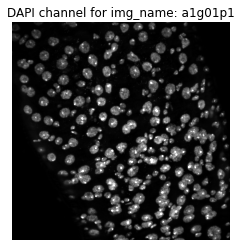

In [ ]:
import matplotlib.pyplot as plt

# display the DAPI channel for the first image
ax = plt.subplots()[1]
ax.imshow(
    exp.image_data["images"].sel(img_channels="C0", img_name="a1g01p1").compute(),
    cmap="gray",
    vmax=12000,
)
ax.set_title("DAPI channel for img_name: a1g01p1")
ax.set_axis_off()

We can add **segmentations** in the same fashion...

**TIP.** 
At a minimum, clonedetective requires a segmentation for the "tot_seg_ch" (see above for definition). If you do not have a suitable segmentation, check out the [example tutorial using StarDist](https://morriso1.github.io/clonedetective/Tutorial_StarDist_Segmentation.html).

In [ ]:
exp.add_segmentations(C0="data/MARCM_experiment/segmentations/C0_stardist_segs/*.tif")

Segmentations have now been added to the Xarray dataset:

In [ ]:
exp.image_data

,Array,Chunk
Bytes,335.38 MiB,1.25 MiB
Shape,"(4, 67, 810, 810)","(1, 1, 810, 810)"
Count,1072 Tasks,268 Chunks
Type,uint16,numpy.ndarray
,Array,Chunk
Bytes,83.84 MiB,1.25 MiB
Shape,"(1, 67, 810, 810)","(1, 1, 810, 810)"
Count,335 Tasks,67 Chunks
Type,uint16,numpy.ndarray


Similarly, we can access specific segmentations using the `.sel` notation:

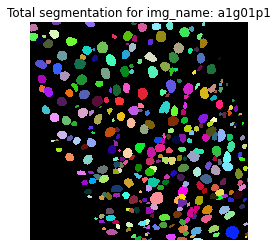

In [ ]:
# random colormap to aid visualization of segmentation:
from clonedetective.utils import generate_random_cmap

# display total segmentation for the first image
ax = plt.subplots()[1]
ax.imshow(
    exp.image_data["segmentations"]
    .sel(seg_channels="C0", img_name="a1g01p1")
    .compute(),
    cmap=generate_random_cmap(),
    interpolation="none",
)
ax.set_title("Total segmentation for img_name: a1g01p1")
ax.set_axis_off()

### Measure cell properties

We next need to measure properties of each segmented cell (label) within our images:

In [ ]:
exp.make_measurements()

Without providing an arguments, `CloneCounter.make_measurements()` defaults to pairing the 'tot_seg_ch' segmentation channel to each of the image channels.

The segmentation-image channel pairs used for cell measurements can be accessed via the `CloneCounter.seg_img_channel_pairs` attribute.

In [ ]:
exp.seg_img_channel_pairs

,segmentation_channel,image_channel
0,C0,C0
1,C0,C1
2,C0,C2
3,C0,C3


**TIP:**
If these segmentation-image channel pairs are unsuitable for your experiment, they can be customised as detailed in the advanced tutorial (coming soon).

**TIP:**
As a default,`CloneCounter.make_measurements()` calculates every cell's mean intensity, centroid, and area. If we require additional measurements, we can supply the `extra_properties` with a list containing any 'regionprops' metrics from the [scikit-image measure module](https://scikit-image.org/docs/dev/api/skimage.measure.html). For example, we can additionally calculate 'eccentricity' as follows:

In [ ]:
exp.make_measurements(extra_properties=["eccentricity"])

The primary result from the `CloneCounter.make_measurements()` call is a `CloneCounter.results_measurements` attribute. This is a pandas DataFrame containing all per cell measurements.

In [ ]:
exp.results_measurements

,seg_ch,int_img_ch,seg_img,int_img,label,area,mean_intensity,centroid-0,centroid-1,eccentricity,area_um2
0,C0,C0,a1g01p1,a1g01p1,1,346,1144.604046,5.054913,97.182081,0.917838,26.166250
1,C0,C0,a1g01p1,a1g01p1,2,574,2557.510453,7.952962,223.238676,0.867292,43.408750
2,C0,C0,a1g01p1,a1g01p1,3,608,3160.207237,13.875000,519.351974,0.515510,45.980000
3,C0,C0,a1g01p1,a1g01p1,4,173,2825.052023,7.283237,644.699422,0.635806,13.083125
4,C0,C0,a1g01p1,a1g01p1,5,168,2858.904762,5.690476,385.523810,0.863300,12.705000
...,...,...,...,...,...,...,...,...,...,...,...
289,C0,C3,a2g13p3,a2g13p3,290,613,96.443719,792.845024,551.652529,0.499582,46.358125
290,C0,C3,a2g13p3,a2g13p3,291,410,76.739024,794.009756,459.451220,0.377639,31.006250
291,C0,C3,a2g13p3,a2g13p3,292,675,31.414815,798.114074,786.000000,0.698885,51.046875
292,C0,C3,a2g13p3,a2g13p3,293,599,95.011686,799.739566,500.397329,0.690486,45.299375


### Test thresholds to define cells as GFP positive or negative

We now aim to determine whether each cell resides inside or outside a "clone". To do this, we first define a 'threshold' that categorises whether a cell is GFP positive or negative. This can be as simple as "mean_intensity > 1000", or involve multiple conditions e.g. "mean_intensity > 1000 & eccentricity > 0.3".

Thresholds are not applied directly to the C1 (GFP) image. Instead, for every label of the total segmentation channel (in this case C0: DAPI), we look at its corresponding intensity in the C1 (GFP) channel. We do this by querying the `CloneCounter.results_measurement` dataframe and keeping only those labels that meet our desired threshold criteria. 

The `CloneCounter` class provides a helper method `testing_possible_thresholds` that can plot and compare different thresholds:

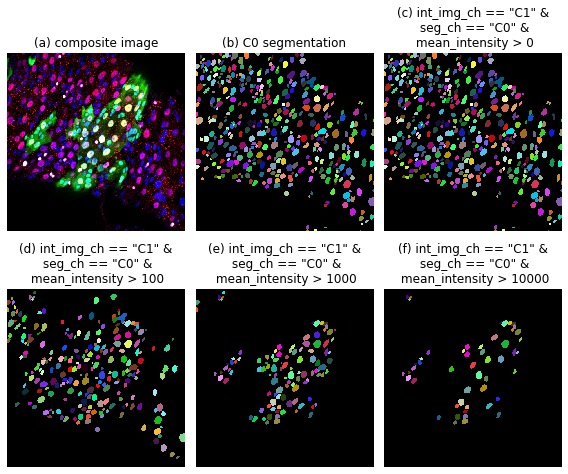

In [ ]:
exp.testing_possible_thresholds(
    int_img="a1g10p1",
    thresholds=[
        ['int_img_ch == "C1" & seg_ch == "C0" & mean_intensity > 0'],
        ['int_img_ch == "C1" & seg_ch == "C0" & mean_intensity > 100'],
        ['int_img_ch == "C1" & seg_ch == "C0" & mean_intensity > 1000'],
        ['int_img_ch == "C1" & seg_ch == "C0" & mean_intensity > 10000'],
    ],
    figure_size=(8, 7),
    interpolation="none",
)

From this test, we can see that a mean intensity threshold of 1000 appears roughly suitable, as its binary image on the left keeps most of the GFP positive cells, while excluding GFP negative cells.

If we were still unhappy with this as a simple threshold, we could increase stringency by adding another threshold on a different cell measurement. Below, we keep a mean intensity threshold constant at 1000, while varying an additional eccentricity threshold:

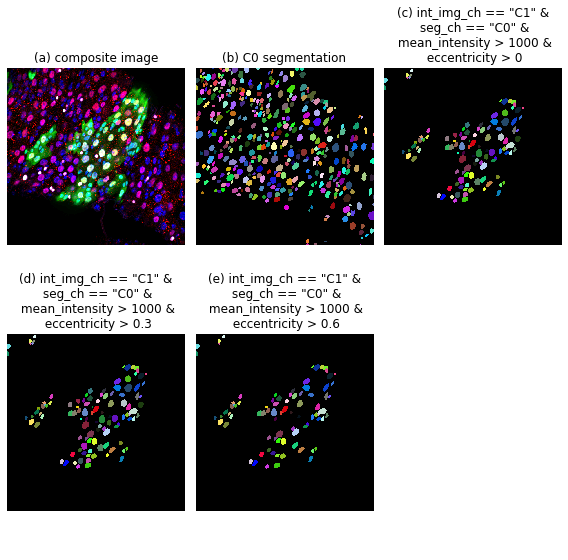

In [ ]:
exp.testing_possible_thresholds(
    int_img="a1g10p1",
    thresholds=[
        [
            'int_img_ch == "C1" & seg_ch == "C0" & mean_intensity > 1000 & eccentricity > 0'
        ],
        [
            'int_img_ch == "C1" & seg_ch == "C0" & mean_intensity > 1000 & eccentricity > 0.3'
        ],
        [
            'int_img_ch == "C1" & seg_ch == "C0" & mean_intensity > 1000 & eccentricity > 0.6'
        ],
    ],
    figure_size=(8, 8),
    interpolation="none",
)

In this example, most cells are pretty round and so both eccentricity == 0 and eccentricity == 0.3 look suitable.

### Define clones and calculate numbers of touching neighbours

Once we have decided on a threshold, we can plug it into the `CloneCounter.add_clones_and_neighbouring_labels` method and apply it to all images:

In [ ]:
exp.add_clones_and_neighbouring_labels(
    thresholds=[
        'int_img_ch == "C1" & seg_ch == "C0" & eccentricity > 0.3 & mean_intensity > 1000'
    ],
    thresh_name="GFP",
    calc_clones=True,
)

This method call does a couple of things:

1) It updates CloneCounter.results_measurements with an additional boolean column describing whether a cell (label) is positive or negative for the desired threshold.

In [ ]:
exp.results_measurements.head()

,seg_ch,int_img_ch,seg_img,int_img,label,area,mean_intensity,centroid-0,centroid-1,eccentricity,area_um2,GFP_clonepos
0,C0,C0,a1g01p1,a1g01p1,1,346,1144.604046,5.054913,97.182081,0.917838,26.16625,False
1,C0,C1,a1g01p1,a1g01p1,1,346,66.199422,5.054913,97.182081,0.917838,26.16625,False
2,C0,C2,a1g01p1,a1g01p1,1,346,777.419075,5.054913,97.182081,0.917838,26.16625,False
3,C0,C3,a1g01p1,a1g01p1,1,346,44.170520,5.054913,97.182081,0.917838,26.16625,False
4,C0,C0,a1g01p1,a1g01p1,2,574,2557.510453,7.952962,223.238676,0.867292,43.40875,False


2) It adds new neighbourhood count and clone images to `CloneCounter.image_data`. (See the additional 'C1' data variable in the Xarray dataset below)

In [ ]:
exp.image_data

,Array,Chunk
Bytes,335.38 MiB,1.25 MiB
Shape,"(4, 67, 810, 810)","(1, 1, 810, 810)"
Count,1072 Tasks,268 Chunks
Type,uint16,numpy.ndarray
,Array,Chunk
Bytes,83.84 MiB,1.25 MiB
Shape,"(1, 67, 810, 810)","(1, 1, 810, 810)"
Count,335 Tasks,67 Chunks
Type,uint16,numpy.ndarray
,Array,Chunk


To illustrate what these new images are, lets plot and walkthrough them for one `img_name` (e.g. "a1g01p1"). As all these new images derive from the original total segmentation image, we will plot this, along with the original fluorescent image (channels C0 and C1).

We first import helper plotting functions from `clonedetective.utils`:

In [ ]:
from clonedetective.utils import RGB_image_from_CYX_img, plot_new_images

In [ ]:
import numpy as np

# grab one img_name from dataset
img = exp.image_data.sel(img_name="a1g01p1")
fluo_img = img["images"].data.compute()

# create RGB image of DAPI and GFP channels
RGB_image = RGB_image_from_CYX_img(
    red=None, green=fluo_img[1, ...], blue=fluo_img[0, ...]
)

# create a list of RGB fluorescent, total segmentation and the new images for easy plotting
img_to_plot = np.concatenate(
    [img["segmentations"].data.compute(), img["GFP"].data.compute()]
)
img_to_plot = [RGB_image] + [img for img in img_to_plot]

# create text labels for our plot
text_labels = ["DAPI + GFP", "total_segmentation"] + img["GFP"].coords[
    "GFP_neighbours"
].values.tolist()

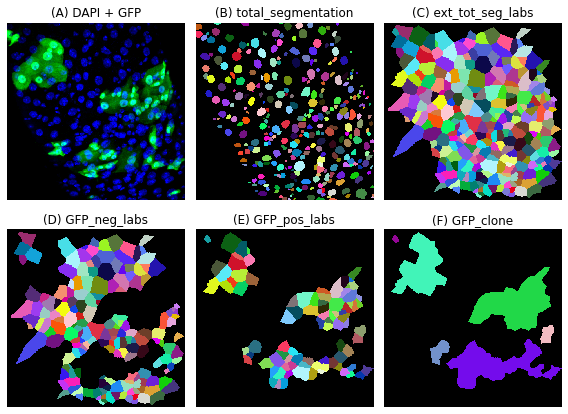

In [ ]:
plot_new_images(
    img_to_plot[:6],
    text_labels[:6],
    "ABCDEF",
    figure_shape=(2, 3),
    figure_size=(8, 6),
    vmax=np.unique(img_to_plot[1]).shape[0],
    interpolation="none",
)

(A) - two channel fluorescent image  
(B) - total segmentation image i.e. from `exp.image_data['segmentations']`.  
(C) - labels of total segmentation image have been extended so they touch each other.  
(D) - labels that **did not** meet our threshold  (C1_neg_labels).  
(E) - labels that **did** meet our threshold  (C1_pos_labels).  
(F) - touching labels that did meet our threshold have been merged into 'clones'

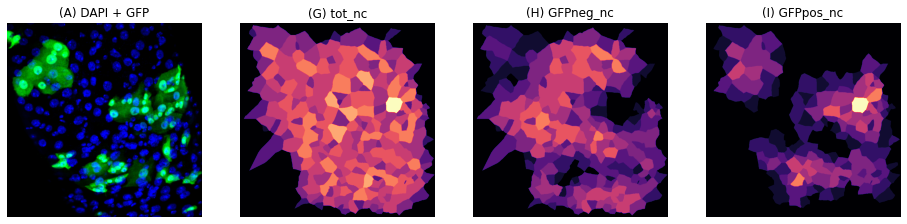

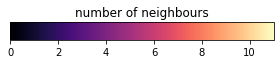

In [ ]:
plot_new_images(
    [img_to_plot[0]] + img_to_plot[6:],
    [text_labels[0]] + text_labels[6:],
    "AGHI",
    figure_shape=(1, 4),
    vmax=np.unique(img_to_plot[6]).shape[0],
    colorbar=True,
    label_cmap="magma",
)

(G) - Parametric image where the number of total neighbours is mapped to color.  
(H) - Parametric image where the number of C1neg neighbours is mapped to color.  
(I) - Parametric image where the number of C1pos neighbours is mapped to color.

### Calculate numbers of touching neighbours for non-clone image channels

As well as a GFP channel, our dataset contains fluorescence channels for PDM1 (channel C2)  and Prospero (channel C3) immunostains. Since PDM1 marks EnteroCyte (EE) cells, and Prospero marks EnteroEndocrine (EE) cells, we can use thresholds to define these cell types within our images.

<img src="docs/images/labelled_cell_types_attempt_2.png">

> Cropped image of intestine stained with <span style="color:blue">DAPI</span>, <span style="color:green">GFP</span>, <span style="color:red">PDM1</span> and <span style="color:gray">Prospero</span> with labelled cell types

First, we define a threshold for EC cells. Since EC are large absorptive cells, we can use total intensity rather than mean intensity for thresholding:

In [ ]:
exp.results_measurements = exp.results_measurements.eval(
    "total_intensity = mean_intensity * area"
)

To find suitable PDM1 (C2) threshold, we can again use the `CloneCounter.testing_possible_thresholds()` method:

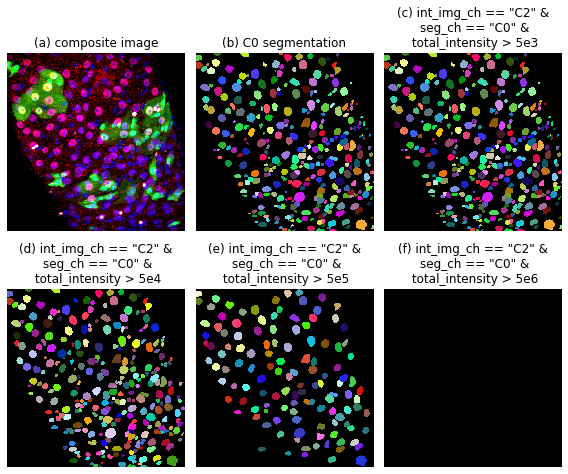

In [ ]:
exp.testing_possible_thresholds(
    int_img="a1g01p1",
    thresholds=[
        ['int_img_ch == "C2" & seg_ch == "C0" & total_intensity > 5e3'],
        ['int_img_ch == "C2" & seg_ch == "C0" & total_intensity > 5e4'],
        ['int_img_ch == "C2" & seg_ch == "C0" & total_intensity > 5e5'],
        ['int_img_ch == "C2" & seg_ch == "C0" & total_intensity > 5e6'],
    ],
    figure_size=(8, 7),
    interpolation="none",
)

So 'total_intensity > 5e5' works well for the PDM1 (C2) channel.

Next, let's find a suitable Prospero threshold to define EE cells:

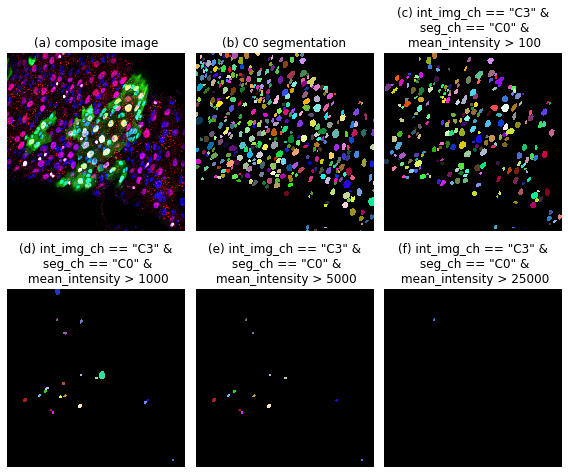

In [ ]:
exp.testing_possible_thresholds(
    int_img="a1g10p1",
    thresholds=[
        ['int_img_ch == "C3" & seg_ch == "C0" & mean_intensity > 100',],
        ['int_img_ch == "C3" & seg_ch == "C0" & mean_intensity > 1000',],
        ['int_img_ch == "C3" & seg_ch == "C0" & mean_intensity > 5000',],
        ['int_img_ch == "C3" & seg_ch == "C0" & mean_intensity > 25000',],
    ],
    figure_size=(8, 7),
    interpolation="none",
)

'mean_intensity > 1000' looks to work well for the Prospero (C3 channel).

**IMP -> However**, it is crucial that threshold definitions for cell types are mutually exclusive i.e. a cell cannot be both EC_pos and EE_pos. If thresholds are not mutually exclusive, the same cell might be counted more than once when we later calculate percentage cell types and the number of neighbours. 

At the moment, our thresholds are not mutually exclusive since there might a small percentage of cells that have PDM1 'total_intensity > 5e5' and Prospero 'mean_intensity' > 1000. We can check this using the `CloneCounter.mutually_exclusive_cell_types()` method after defining out initial cell type thresholds:

In [ ]:
exp.add_clones_and_neighbouring_labels(
    thresholds=['int_img_ch == "C2" & seg_ch == "C0" & total_intensity > 5e5',],
    thresh_name="EC",
    calc_clones=False,
)

exp.add_clones_and_neighbouring_labels(
    thresholds=['int_img_ch == "C3" & seg_ch == "C0" & mean_intensity > 1000',],
    thresh_name="EE",
    calc_clones=False,
)

In [ ]:
exp.mutually_exclusive_cell_types()

False

To avoid this problem, we can define an additional double positive cell type (ECEC), and more precisely define our cell types as:
- EC cells : positive for PDM1 (channel C2), negative for Prospero (channel C3).  
- EE cells : negative for PDM1 (channel C2), positive for Prospero (channel C3).  
- ECEE cells : positive for PDM1 (channel C2), positive for Prospero (channel C3)

In [ ]:
exp.add_clones_and_neighbouring_labels(
    thresholds=[
        'int_img_ch == "C2" & seg_ch == "C0" & total_intensity > 5e5',
        'int_img_ch == "C3" & seg_ch == "C0" & mean_intensity < 1000',
    ],
    thresh_name="EC",
    calc_clones=False,
)

In [ ]:
exp.add_clones_and_neighbouring_labels(
    thresholds=[
        'int_img_ch == "C2" & seg_ch == "C0" & total_intensity < 5e5',
        'int_img_ch == "C3" & seg_ch == "C0" & mean_intensity > 1000',
    ],
    thresh_name="EE",
    calc_clones=False,
)

In [ ]:
exp.add_clones_and_neighbouring_labels(
    thresholds=[
        'int_img_ch == "C2" & seg_ch == "C0" & total_intensity > 5e5',
        'int_img_ch == "C3" & seg_ch == "C0" & mean_intensity > 1000',
    ],
    thresh_name="ECEE",
    calc_clones=False,
)

Now check again:

In [ ]:
exp.mutually_exclusive_cell_types()

True

The final major cell type within the fly intestine are progenitor cells including Intestinal Stem Cells (ISCs) and EnteroBlasts (EBs). These can be defined as having small nuclei and *not* being 'EC_pos',  'EE_pos' nor 'ECEC_pos':

In [ ]:
exp.add_clones_and_neighbouring_labels(
    thresholds=["area_um2 < 50 & not EC_pos & not EE_pos & not ECEE_pos"],
    thresh_name="ISCorEB",
    calc_clones=False,
)

**IMP -> However**, as well as being mutally exclusive, our cell type thresholds also need to completely categorise every cell. At the moment, this is not the case, since large nuclei cells that are not 'EC_pos',  'EE_pos' nor 'ECEC_pos', have not been classified.

We can check using the following method:

In [ ]:
exp.complete_set_of_cell_types()

False

We, therefore, define a threshold for a rare preEC cell type, which have large nuclei but are not 'EC_pos',  'EE_pos' nor 'ECEC_pos'.

In [ ]:
exp.add_clones_and_neighbouring_labels(
    # could also be defined as ["not EC_pos & not EE_pos & not ECEE_pos & not ISCorEB_pos"]
    thresholds=["area_um2 > 50 & not EC_pos & not EE_pos & not ECEE_pos"],
    thresh_name="preEC",
    calc_clones=False,
)

This completes our cell type thresholding:

In [ ]:
exp.mutually_exclusive_cell_types(), exp.complete_set_of_cell_types()

(True, True)

### Quantify clone and the touching neighbours

We now quantify numbers of clones and touching neighbours.

In [ ]:
exp.measure_all_clones_and_neighbouring_labels()

This operation populates a `CloneCounter.results_clones_and_neighbour_counts` dictionary attribute with pandas dataframes for each defined cell type or clone threshold:

In [ ]:
exp.results_clones_and_neighbour_counts.keys()

dict_keys(['GFP', 'EC', 'EE', 'ECEE', 'ISCorEB', 'preEC'])

Each dataframe contains neighbour count information for that cell type e.g.

In [ ]:
exp.results_clones_and_neighbour_counts["GFP"].head()

GFP_neighbours  GFP_clone  GFPneg_nc  GFPpos_nc  tot_nc
int_img label                                          
a1g01p1 11              0          2          2       4
        12              0          4          0       4
        15              0          2          0       2
        17              2          2          0       2
        18              0          2          0       2

Next, we combine these dataframes together, along with the original `CloneCounter.results_measurements` dataframe, to return a final dataframe that contains information on all cell properties (e.g. mean_intensity), whether a cell inside a clone, and the number and type of neighbours a cell has:

In [ ]:
df = exp.combine_neighbour_counts_and_measurements()

### Data export for downstream analysis

We can now export this DataFrame for future downstream analysis using your favourite data wrangling and plotting tools.

In [ ]:
# export of results:
df.to_csv("data/example_results.csv", index=False)

To follow on with these analyses, please see tutorials:
- [downstream analysis using Python](https://morriso1.github.io/clonedetective/Tutorial_Downstream_Analysis_Python.html)  
- [downstream analysis using R](https://morriso1.github.io/clonedetective/Tutorial_Downstream_Analysis_R.html)   